In [1]:
# Import Packages
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from scipy.stats import uniform
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For GPU training, set the following:
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Load the dataset
df = pd.read_csv('Heart_Disease.csv')

In [4]:
# Display the first few rows of the DataFrame
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# Summary of the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
# Descriptive statistics for numerical columns
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


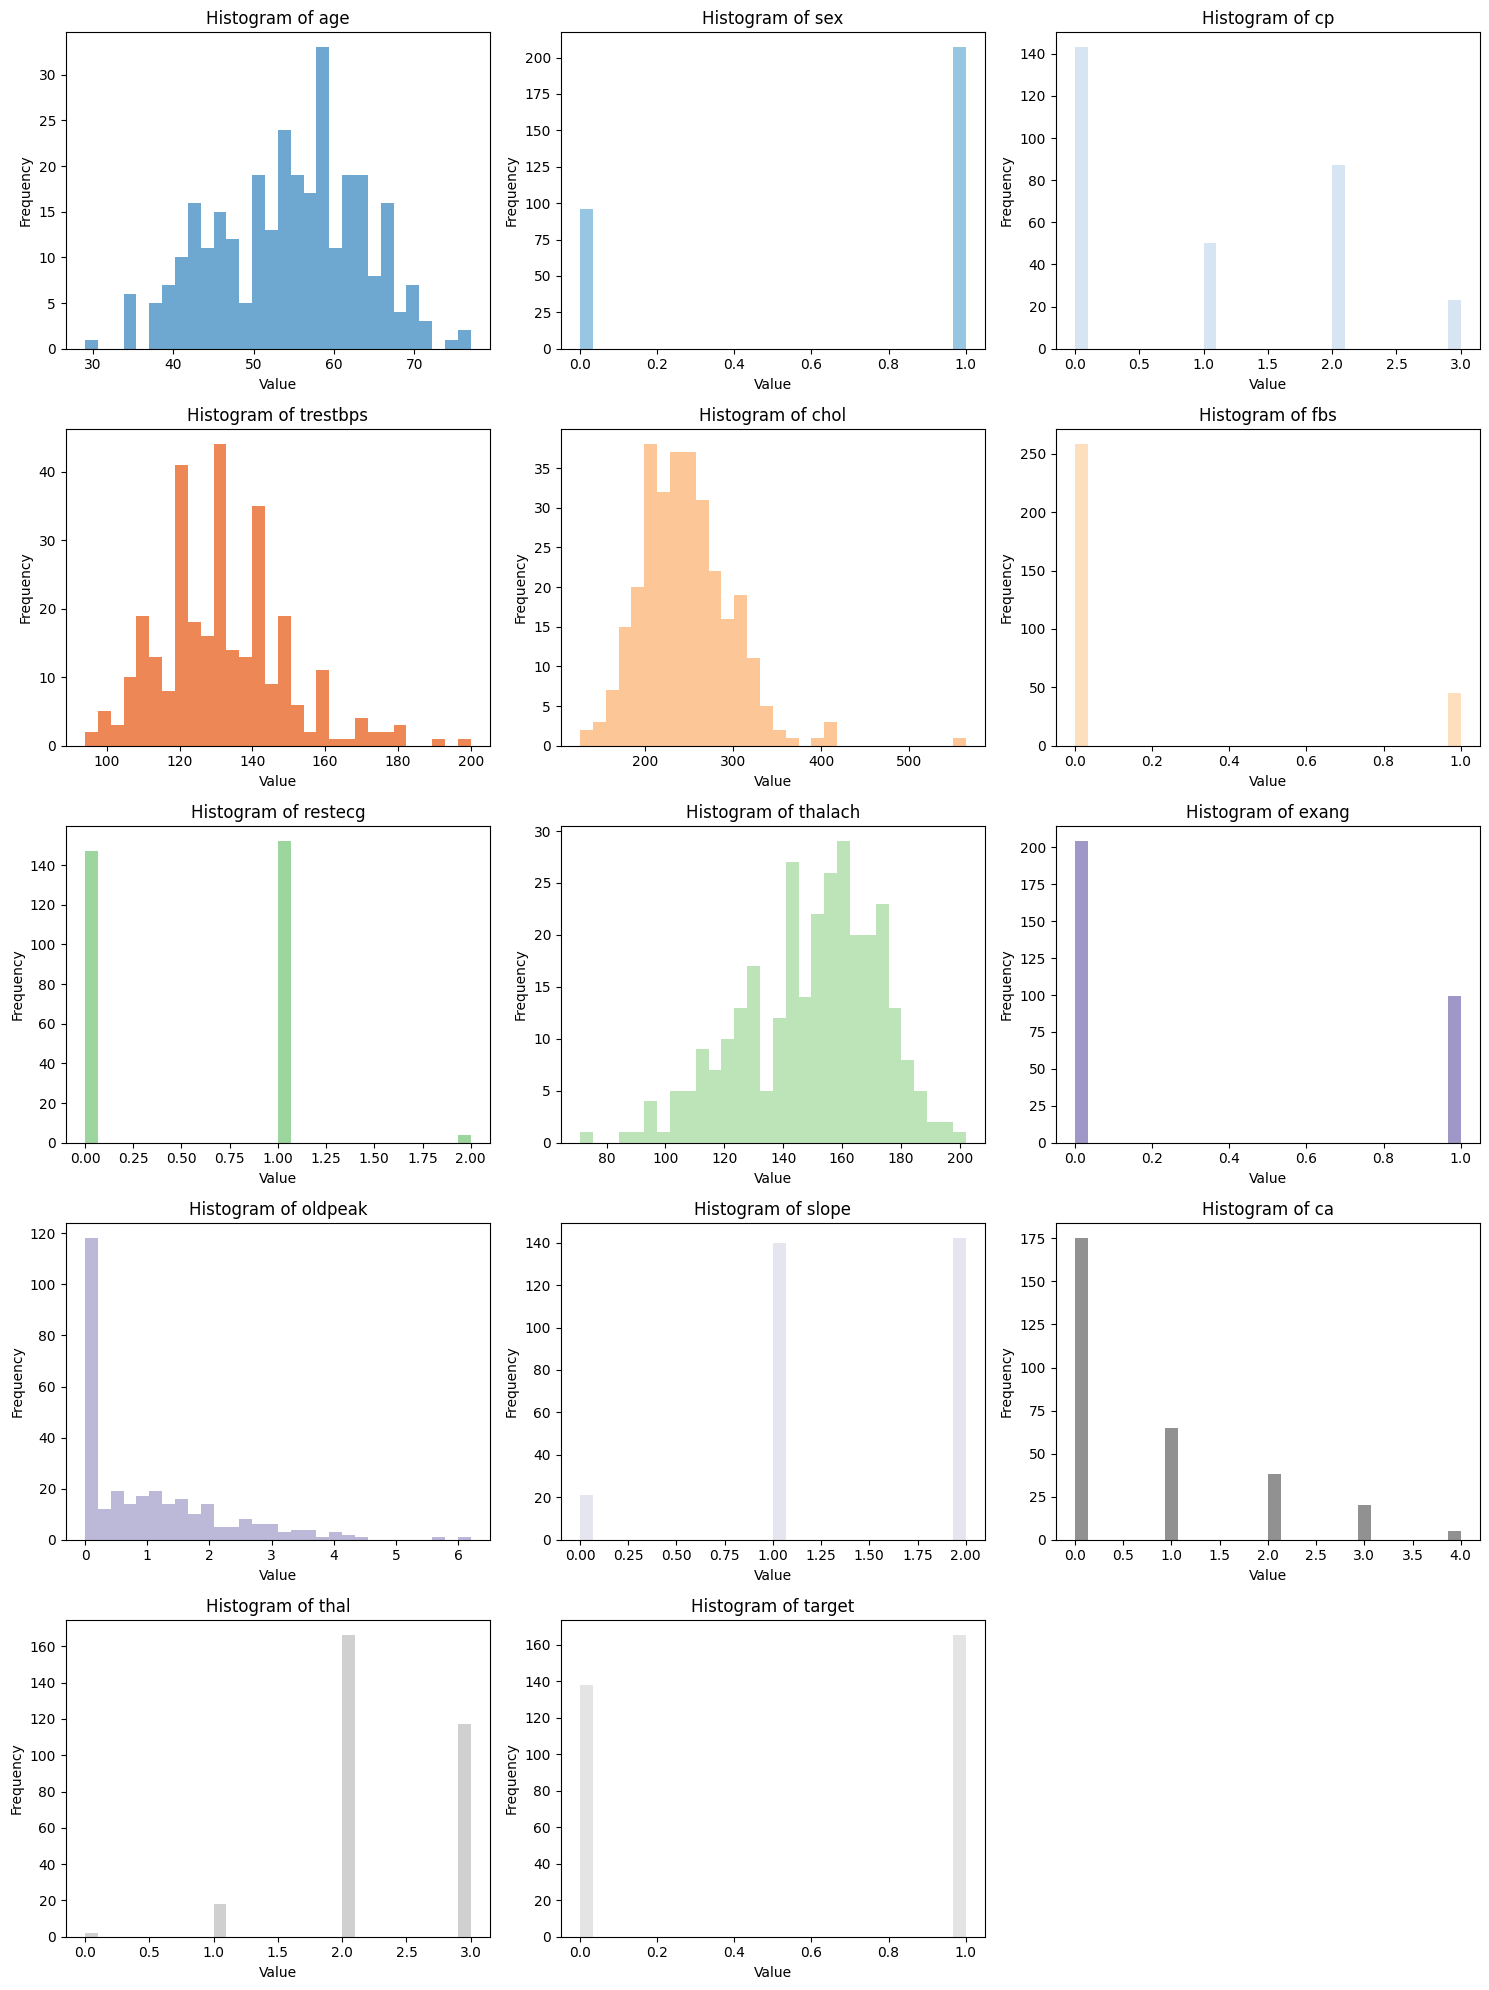

In [7]:
# Histograms of Features

features = df.columns  # Get the list of feature names
colormap = plt.colormaps.get_cmap('tab20c') # Generate a colormap with 'tab20c'
colors = [colormap(i / max(len(features)-1, 1)) for i in range(len(features))]  # Ensure unique colors

# Set the number of columns for the subplots
num_cols = 3
num_rows = len(features) // num_cols + (len(features) % num_cols > 0)  # Calculate the number of rows needed

# Create subplots - one for each feature
plt.figure(figsize=(15, 4 * num_rows))  # Adjust the figure size based on the number of rows

for i, feature in enumerate(features):
    plt.subplot(num_rows, num_cols, i + 1)  # Arrange subplots in a grid with 3 columns
    plt.hist(df[feature], bins=30, color=colors[i], alpha=0.7)
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

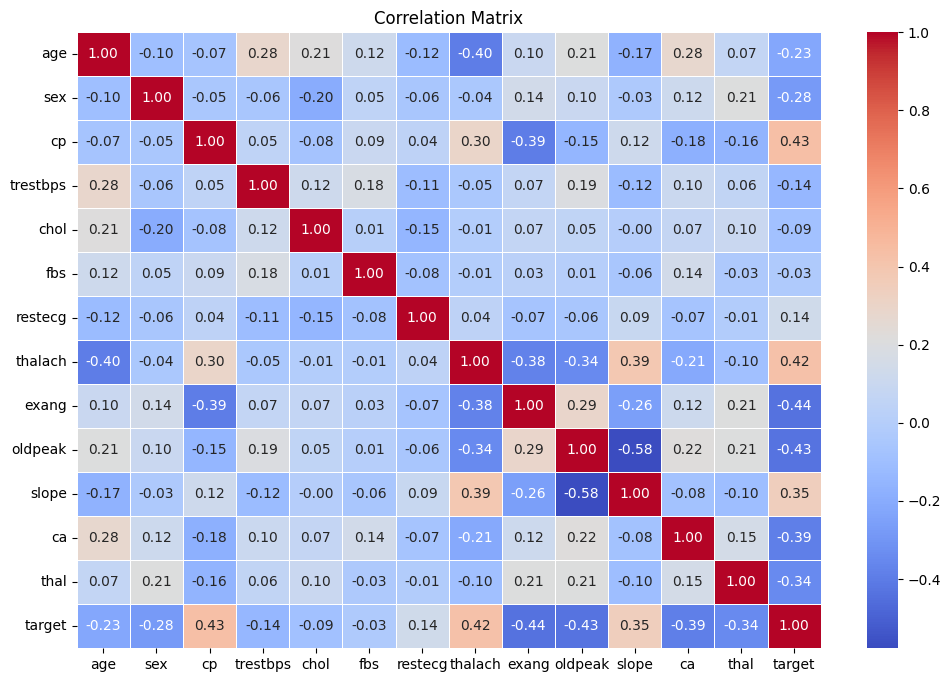

In [8]:
# Correlation Matrix with Heatmap

corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

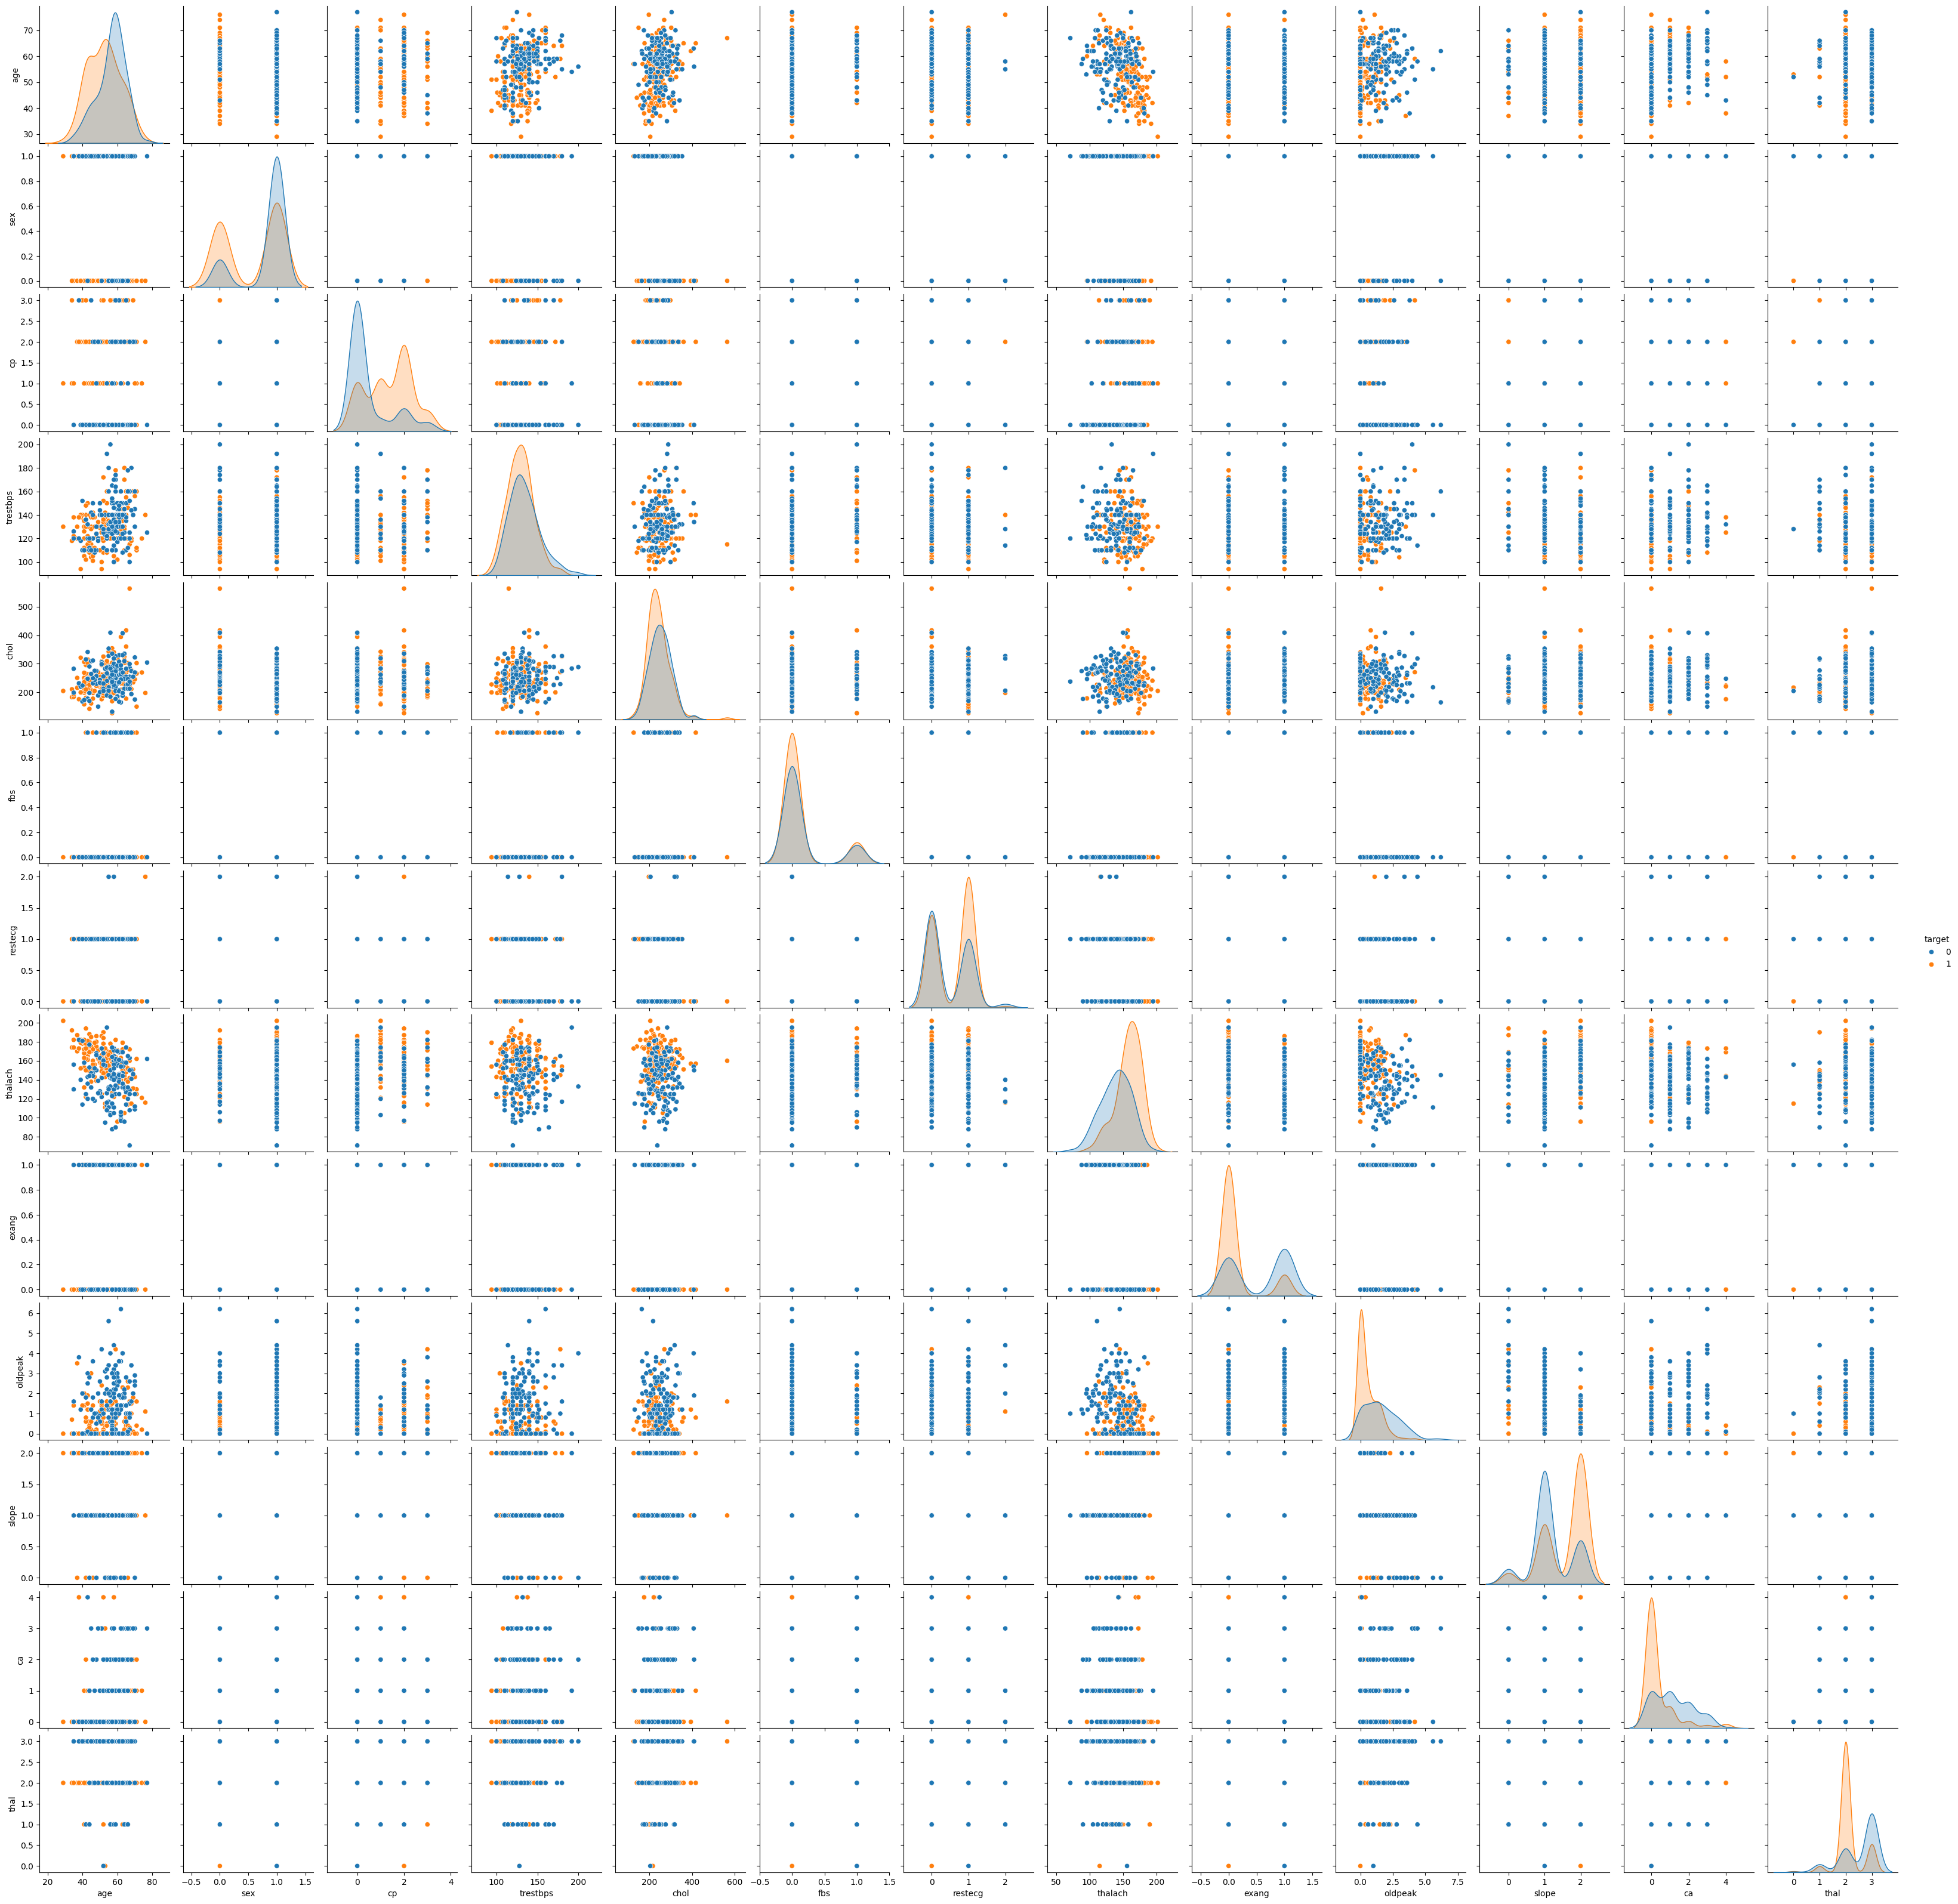

In [9]:
# Pair Plot (Scatterplot Matrix)

sns.pairplot(df, hue='target')
plt.show()

In [10]:
# Feature selection and target variable
X = df.drop(columns='target')
y = df['target'] # heart disease status

In [11]:
# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [13]:
# Define the neural network
class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = HeartDiseaseNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training loop
epochs = 100
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    current_loss = loss.item()
    loss_values.append(current_loss)
    loss.backward()

    with torch.no_grad():
        outputs = model(X_train).squeeze()
        predicted = (outputs >= 0.5).float()  # Assuming binary classification with a threshold of 0.5
        accuracy = (predicted == y_train).float().mean().item()

    # Append the accuracy value to the list
    accuracy_values.append(accuracy)
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.6584
Epoch [20/100], Loss: 0.6032
Epoch [30/100], Loss: 0.5349
Epoch [40/100], Loss: 0.4633
Epoch [50/100], Loss: 0.4033
Epoch [60/100], Loss: 0.3607
Epoch [70/100], Loss: 0.3316
Epoch [80/100], Loss: 0.3105
Epoch [90/100], Loss: 0.2928
Epoch [100/100], Loss: 0.2764


In [15]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test).squeeze()
    predicted = (test_outputs >= 0.5).float()  # Apply threshold
    accuracy = (predicted == y_test).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

Accuracy: 86.89%


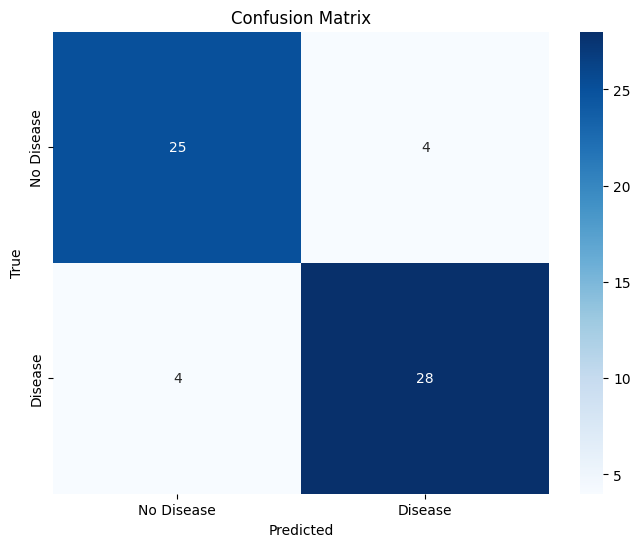

In [16]:
# Confusion Matrix

# Get the model's predicted labels
with torch.no_grad():
    y_pred_prob = model(X_test).squeeze()
    y_pred = (y_pred_prob >= 0.5).float()  # Apply threshold to get binary predictions

# Convert to numpy array if needed
y_pred = y_pred.numpy()
y_test = y_test.numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

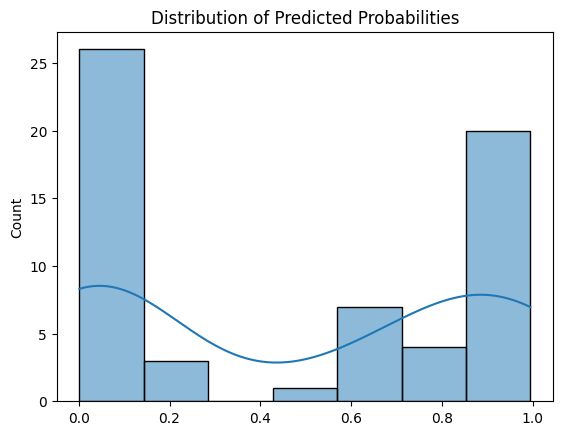

In [17]:
# Distribution of Predictions

sns.histplot(y_pred_prob, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.show()

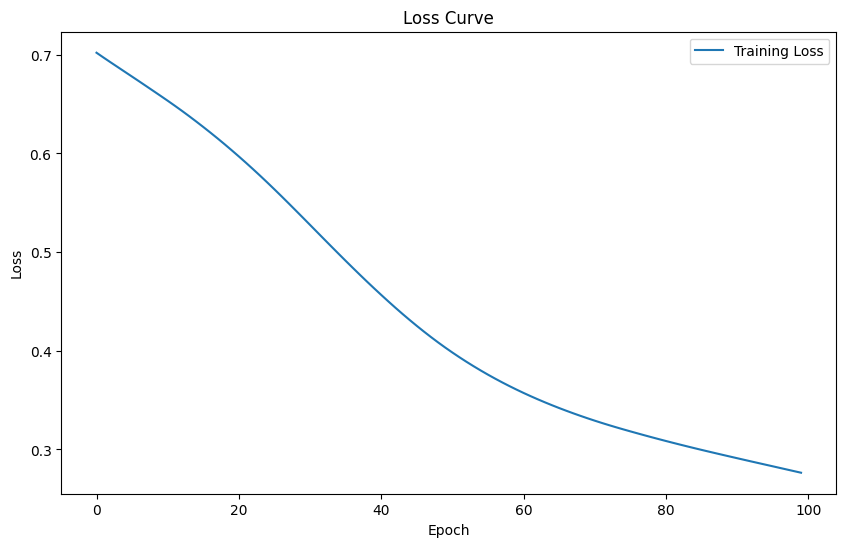

In [18]:
# Plot the loss function

plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

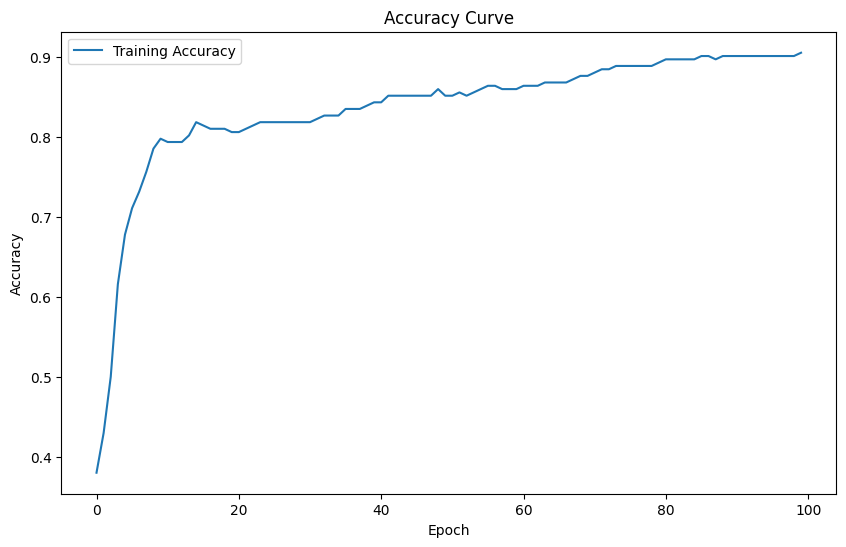

In [19]:
# Plot the accuracy function

plt.figure(figsize=(10, 6))
plt.plot(accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

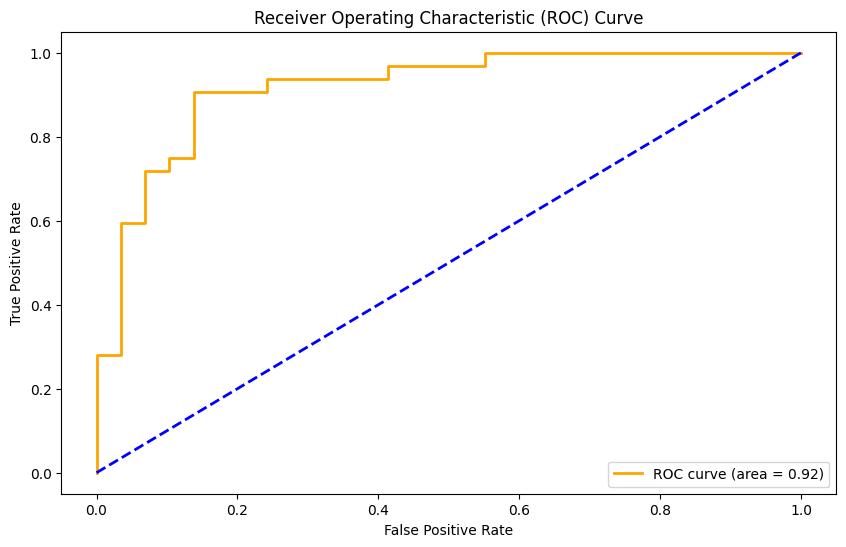

In [20]:
# ROC Curve

with torch.no_grad():
    y_pred_prob = model(X_test).squeeze()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', lw=2)  # Diagonal line (random chance)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

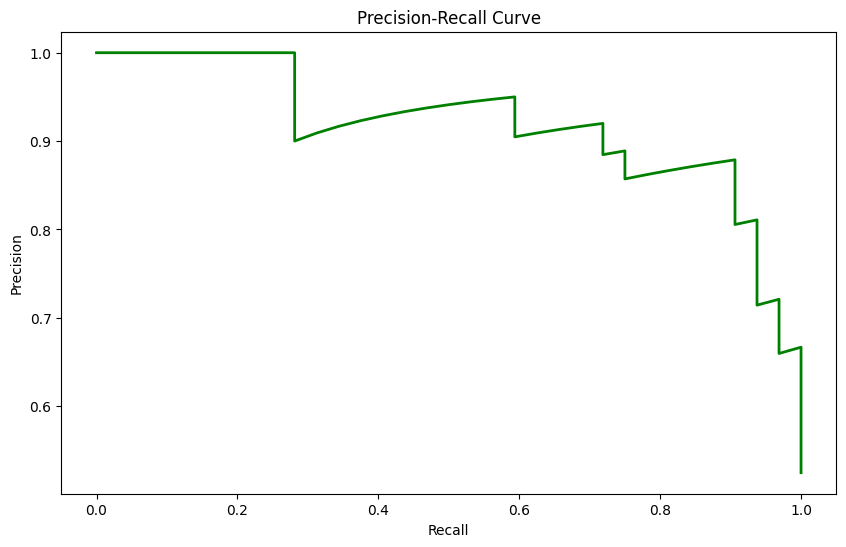

In [21]:
# Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

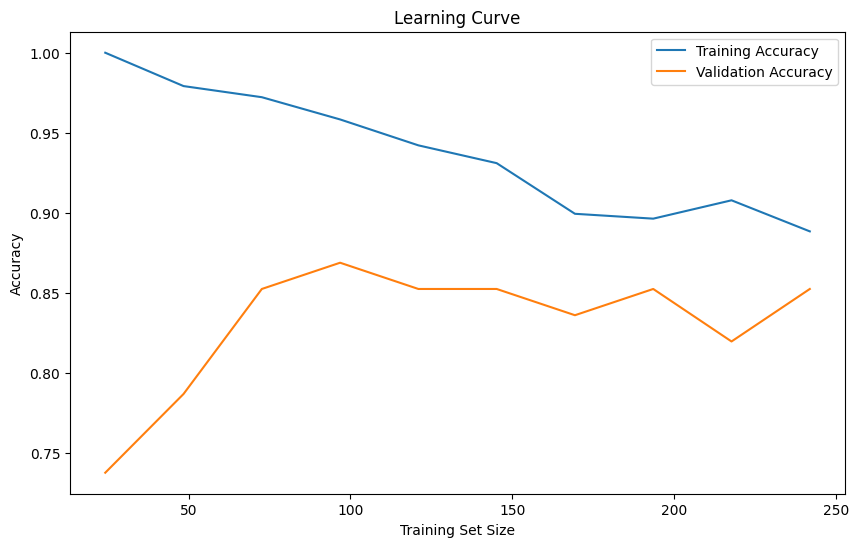

In [22]:
# Learning Curve

# Define a function to train the model on a subset of the data
def train_model_on_subset(X_train_subset, y_train_subset):
    model = HeartDiseaseNN()
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_subset).squeeze()
        loss = criterion(outputs, y_train_subset)
        loss.backward()
        optimizer.step()
    
    return model

# Define the sizes of the training set to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Arrays to hold the training and validation scores
train_scores = []
val_scores = []

# Loop over the different training set sizes
for train_size in train_sizes:
    # Determine the number of samples in this subset
    n_samples = int(len(X_train) * train_size)
    
    # Select the subset of the data
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]
    
    # Train the model on this subset
    model = train_model_on_subset(X_train_subset, y_train_subset)
    
    # Calculate the accuracy on the training subset
    with torch.no_grad():
        train_outputs = model(X_train_subset).squeeze()
        train_predicted = (train_outputs >= 0.5).float()
        train_accuracy = (train_predicted == y_train_subset).float().mean().item()
        train_scores.append(train_accuracy)
    
    # Calculate the accuracy on the full validation set
    with torch.no_grad():
        val_outputs = model(X_test).squeeze()
        val_predicted = (val_outputs >= 0.5).float()
        val_accuracy = (val_predicted == y_test).float().mean().item()
        val_scores.append(val_accuracy)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

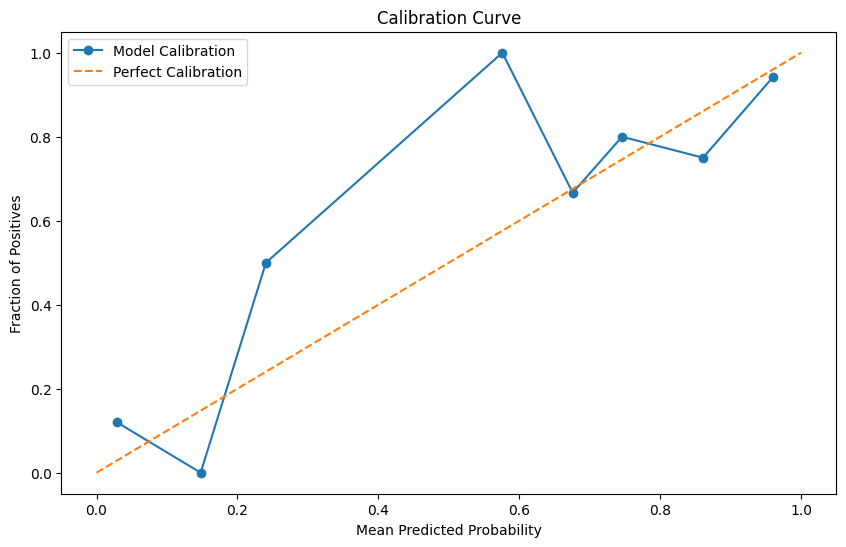

In [23]:
# Calibration Curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [24]:
# K-Fold Cross-Validation

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)

class HeartDiseaseNN(nn.Module):
    def __init__(self):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Arrays to hold accuracy and loss scores
fold_accuracies = []
fold_losses = []

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    # Split data into training and validation sets
    X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y[train_idx].values, dtype=torch.float32)
    X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
    y_val_fold = torch.tensor(y[val_idx].values, dtype=torch.float32)
    
    # Initialize the model, loss function, and optimizer
    model = HeartDiseaseNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop for this fold
    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_fold).squeeze()
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()
    
    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_fold).squeeze()
        val_predicted = (val_outputs >= 0.5).float()
        val_accuracy = (val_predicted == y_val_fold).float().mean().item()
        fold_loss = criterion(val_outputs, y_val_fold).item()

    # Record the performance metrics for this fold
    fold_accuracies.append(val_accuracy)
    fold_losses.append(fold_loss)
    print(f'Fold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}, Loss: {fold_loss:.4f}')

# Calculate the average accuracy and loss across all folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)
print(f'\nAverage Accuracy: {average_accuracy:.4f}')
print(f'Average Loss: {average_loss:.4f}')


Fold 1 - Validation Accuracy: 0.8065, Loss: 0.5210
Fold 2 - Validation Accuracy: 0.9355, Loss: 0.2508
Fold 3 - Validation Accuracy: 0.7742, Loss: 0.4734
Fold 4 - Validation Accuracy: 0.8667, Loss: 0.3808
Fold 5 - Validation Accuracy: 0.8667, Loss: 0.3536
Fold 6 - Validation Accuracy: 0.8000, Loss: 0.4455
Fold 7 - Validation Accuracy: 0.7000, Loss: 0.5324
Fold 8 - Validation Accuracy: 0.8000, Loss: 0.3612
Fold 9 - Validation Accuracy: 0.8333, Loss: 0.3312
Fold 10 - Validation Accuracy: 0.8667, Loss: 0.3559

Average Accuracy: 0.8249
Average Loss: 0.4006


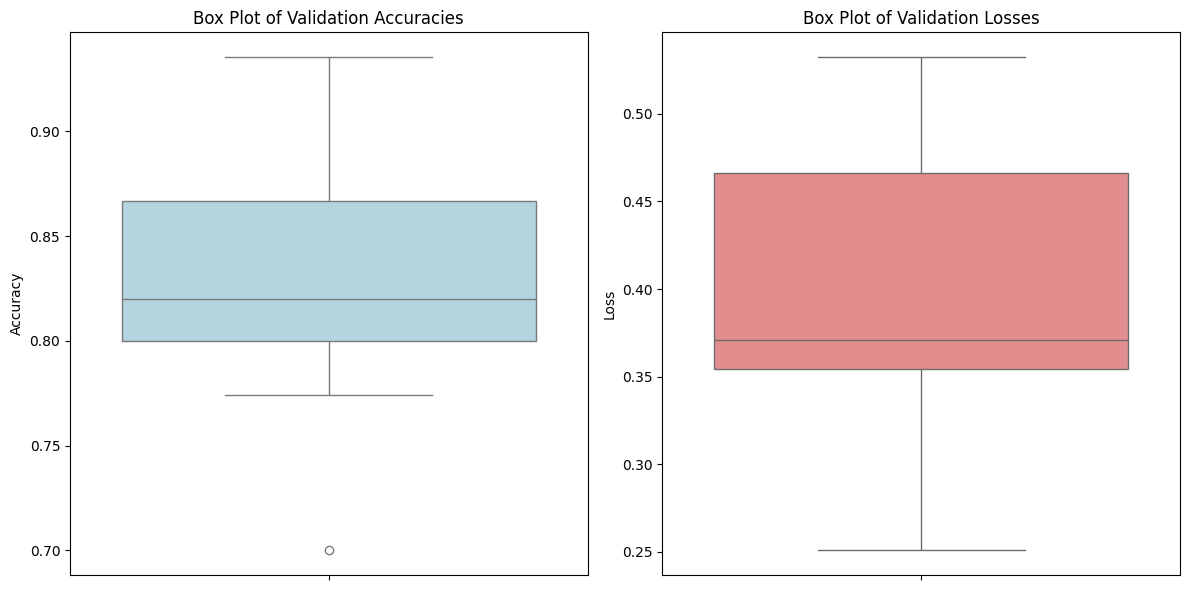

In [25]:
# Create a DataFrame for easier plotting with Seaborn
df_results = pd.DataFrame({
    'Fold': list(range(1, len(fold_accuracies) + 1)),
    'Accuracy': fold_accuracies,
    'Loss': fold_losses
})

# Box plot for Accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_results, y='Accuracy', color='lightblue')
plt.title('Box Plot of Validation Accuracies')

# Box plot for Losses
plt.subplot(1, 2, 2)
sns.boxplot(data=df_results, y='Loss', color='lightcoral')
plt.title('Box Plot of Validation Losses')

plt.tight_layout()
plt.show()


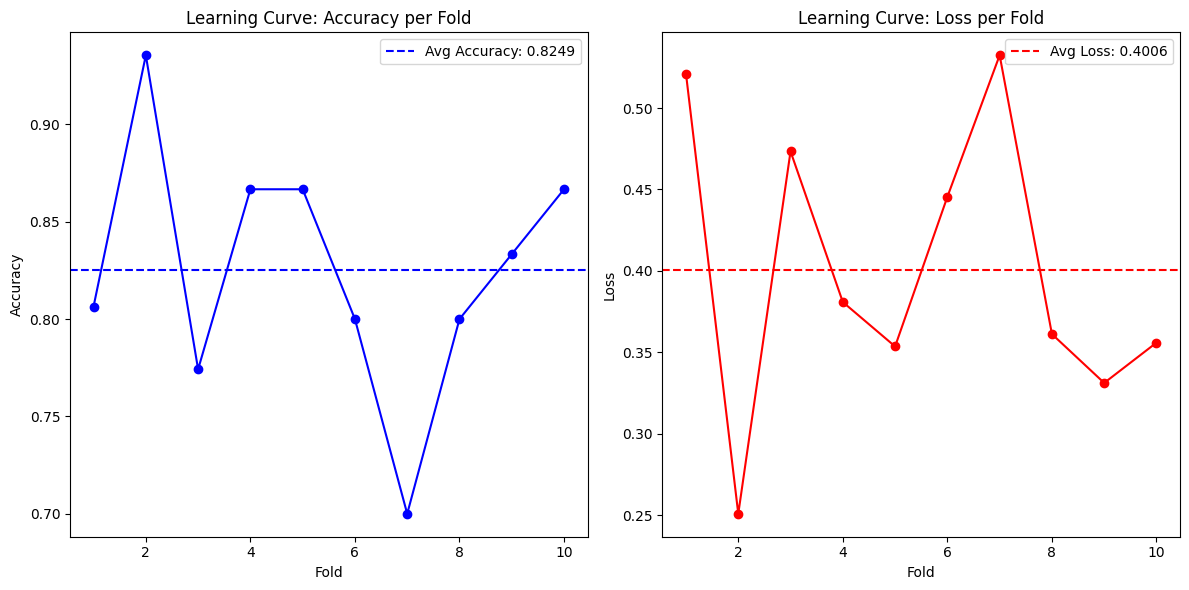

In [26]:
plt.figure(figsize=(12, 6))

# Plot average accuracy and loss across folds
plt.subplot(1, 2, 1)
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=np.mean(fold_accuracies), color='b', linestyle='--', label=f'Avg Accuracy: {np.mean(fold_accuracies):.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy per Fold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(fold_losses) + 1), fold_losses, marker='o', linestyle='-', color='r')
plt.axhline(y=np.mean(fold_losses), color='r', linestyle='--', label=f'Avg Loss: {np.mean(fold_losses):.4f}')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss per Fold')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Hyperparameter Tuning

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)

# Define the PyTorch neural network model as a scikit-learn compatible estimator
class PyTorchNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden1=64, n_hidden2=32, learning_rate=0.001):
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.learning_rate = learning_rate
        self.model = None
        self.loss_values = []  # List to store loss values
        self.accuracy_values = []  # List to store accuracy values
    
    def build_model(self, input_dim):
        self.model = nn.Sequential(
            nn.Linear(input_dim, self.n_hidden1),
            nn.ReLU(),
            nn.Linear(self.n_hidden1, self.n_hidden2),
            nn.ReLU(),
            nn.Linear(self.n_hidden2, 1),
            nn.Sigmoid()
        )
    
    def fit(self, X, y):
        if isinstance(X, torch.Tensor):
            X = X.clone().detach().float()
        else:
            X = torch.tensor(X, dtype=torch.float32)
        
        if isinstance(y, torch.Tensor):
            y = y.clone().detach().float()
        else:
            y = torch.tensor(y, dtype=torch.float32)
        
        self.build_model(X.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        for epoch in range(100):  # Fixed number of epochs for simplicity
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # Store the loss value
            self.loss_values.append(loss.item())
            
            # Calculate and store accuracy
            with torch.no_grad():
                predictions = (outputs >= 0.5).float()
                accuracy = (predictions == y).float().mean().item()
                self.accuracy_values.append(accuracy)
    
    def predict(self, X):
        if isinstance(X, torch.Tensor):
            X = X.clone().detach().float()
        else:
            X = torch.tensor(X, dtype=torch.float32)
        
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X).squeeze()
            predictions = (outputs >= 0.5).float().numpy()
        return predictions
    
    def predict_proba(self, X):
        if isinstance(X, torch.Tensor):
            X = X.clone().detach().float()
        else:
            X = torch.tensor(X, dtype=torch.float32)
        
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X).squeeze()
            probabilities = outputs.numpy()  # The output is the probability since Sigmoid is the last layer
        return np.vstack([1 - probabilities, probabilities]).T  # Return an array with two columns: [1-prob, prob]

In [28]:
# Perform Random Search or Grid Search

# Convert data back to numpy arrays
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()

# Define the hyperparameter grid
param_grid = {
    'n_hidden1': [32, 64, 128],
    'n_hidden2': [16, 32, 64],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]
}

# Initialize the model
model = PyTorchNN()

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)
grid_search.fit(X_train_np, y_train_np)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=16; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=16; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=16; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=32; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=32; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=32; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=64; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=64; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=32, n_hidden2=64; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=64, n_hidden2=16; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=64, n_hidden2=16; total time=   0.0s
[CV] END ....learning_rate=0.001, n_hidden1=64,

GridSearchCV(cv=3, estimator=PyTorchNN(),
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'n_hidden1': [32, 64, 128],
                         'n_hidden2': [16, 32, 64]},
             verbose=2)

In [29]:
# Best hyperparameters and performance
print('Best Parameters:', grid_search.best_params_)
print(f'Best Score: {grid_search.best_score_:.4f}')

Best Parameters: {'learning_rate': 0.001, 'n_hidden1': 32, 'n_hidden2': 16}
Best Score: 0.8142


In [30]:
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Test Accuracy: 85.25%
Confusion Matrix:
 [[25  4]
 [ 5 27]]


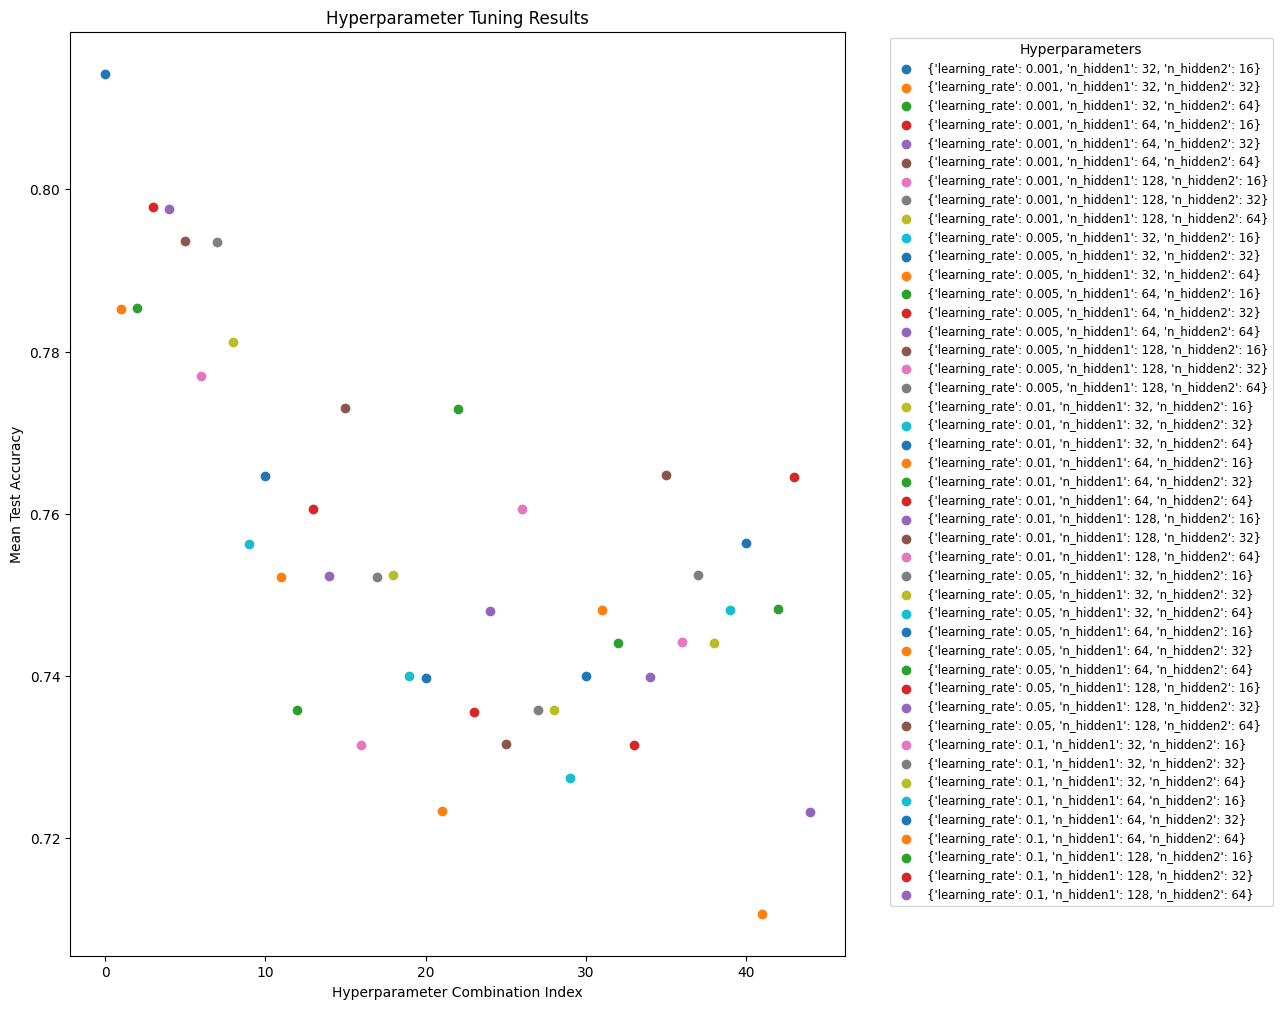

In [31]:
# Plot the Performance of Different Hyperparameter Combinations

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Plot accuracy scores for each hyperparameter combination
plt.figure(figsize=(10, 12))

# Hyperparameter combinations are stored in the param_grid attribute
for i, param in enumerate(results['params']):
    plt.scatter(i, results['mean_test_score'][i], label=str(param))

plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Test Accuracy')
plt.title('Hyperparameter Tuning Results')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title='Hyperparameters')
plt.show()

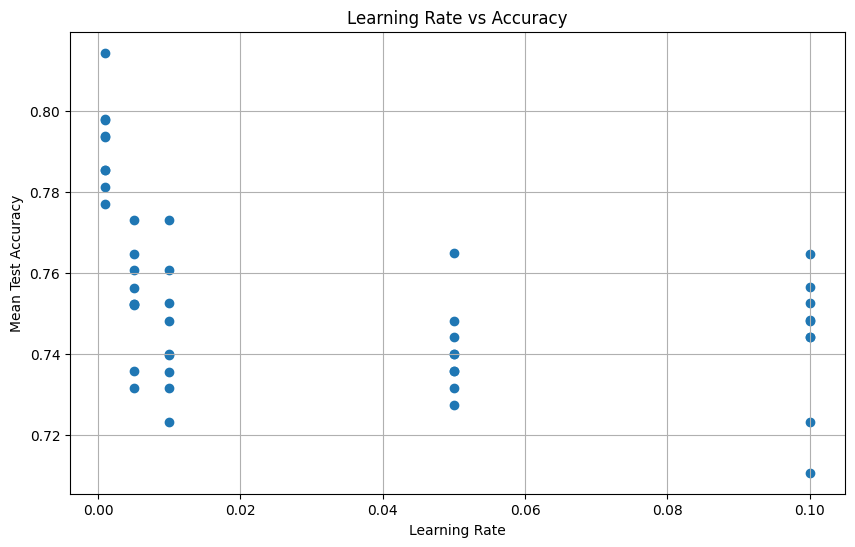

In [32]:
# Hyperparameter Distribution with Performance

plt.figure(figsize=(10, 6))

# Plot learning rate vs accuracy
learning_rates = [result['learning_rate'] for result in results['params']]
accuracies = results['mean_test_score']
plt.scatter(learning_rates, accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Accuracy')
plt.title('Learning Rate vs Accuracy')
plt.grid(True)
plt.show()

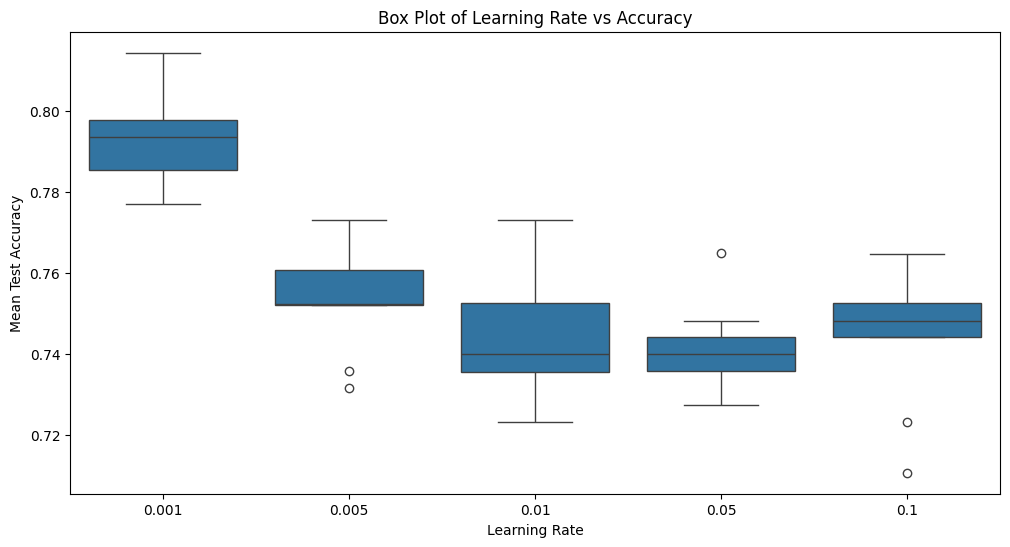

In [33]:
# Box Plot of Accuracies Across Different Hyperparameters

# Convert results to a DataFrame
df_results = pd.DataFrame(results['params'])
df_results['mean_test_score'] = results['mean_test_score']

# Boxplot of accuracies for each hyperparameter setting
plt.figure(figsize=(12, 6))
sns.boxplot(x='learning_rate', y='mean_test_score', data=df_results)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Accuracy')
plt.title('Box Plot of Learning Rate vs Accuracy')
plt.show()

In [34]:
# Train the Final Model with Optimal Parameters

# Extract the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Initialize the final model with the best hyperparameters
final_model = PyTorchNN(n_hidden1=best_params['n_hidden1'], 
                        n_hidden2=best_params['n_hidden2'], 
                        learning_rate=best_params['learning_rate'])

# Convert training data to numpy arrays if necessary
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()

# Train the final model on the entire training set
final_model.fit(X_train_np, y_train_np)

In [35]:
# Evaluate the Model on the Test Set

# Predict on the test set
y_pred = final_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f'Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Test Accuracy: 86.89%
Confusion Matrix:
 [[25  4]
 [ 4 28]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        29
         1.0       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [36]:
# Cross-Validation

# Perform cross-validation
cross_val_scores = cross_val_score(final_model, X_train_np, y_train_np, cv=5)
rounded_scores = np.round(cross_val_scores, 4)

print(f'Cross-Validation Scores: {rounded_scores}')  # Prints the array of scores
print(f'Mean Cross-Validation Score: {rounded_scores.mean()}')

Cross-Validation Scores: [0.8367 0.8367 0.7708 0.8958 0.8125]
Mean Cross-Validation Score: 0.8305


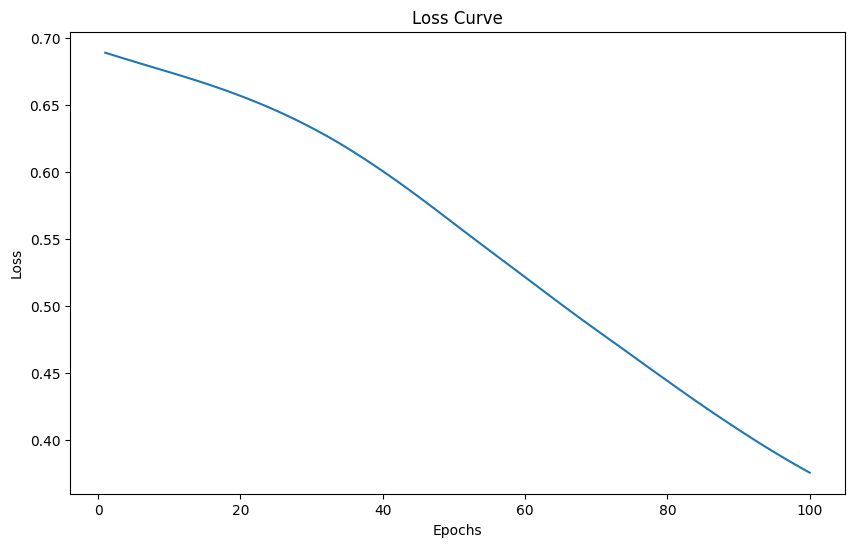

In [37]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(final_model.loss_values) + 1), final_model.loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

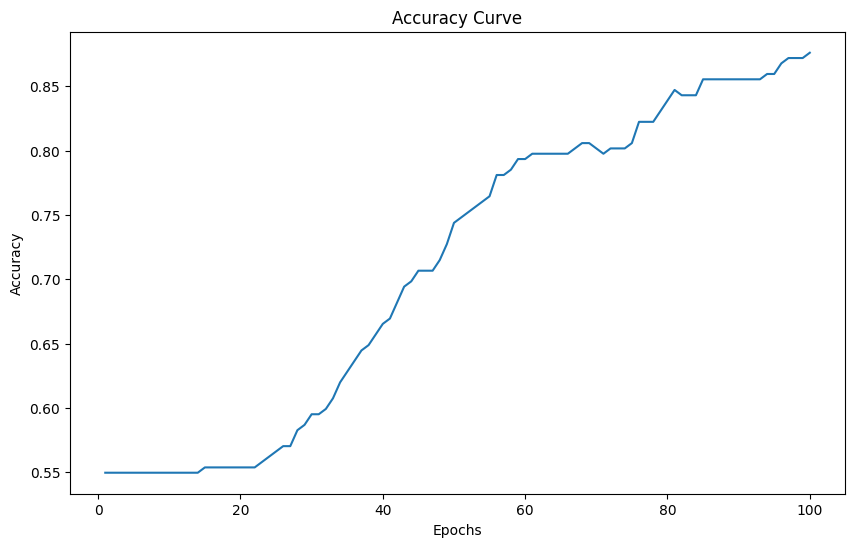

In [38]:
# Plot the accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(final_model.accuracy_values) + 1), final_model.accuracy_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.show()

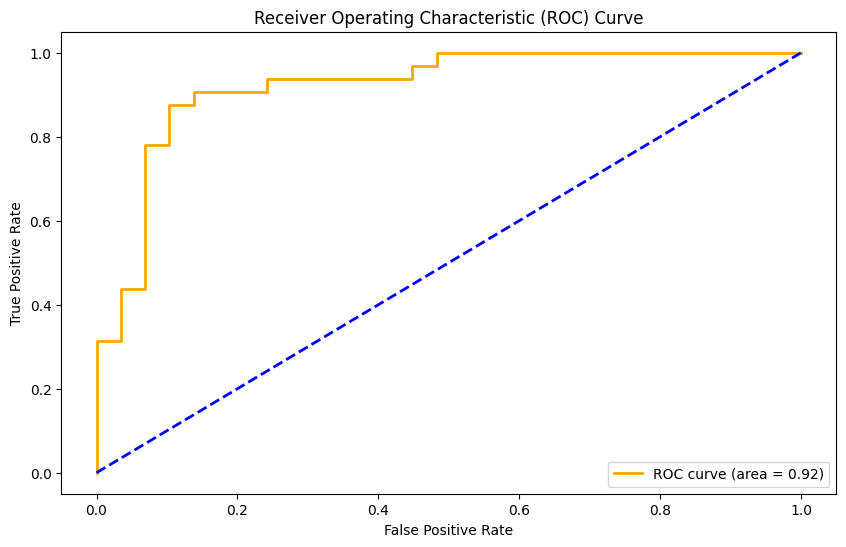

In [39]:
# ROC Curve

# Predict probabilities on the test set
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', lw=2)  # Diagonal line (random chance)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

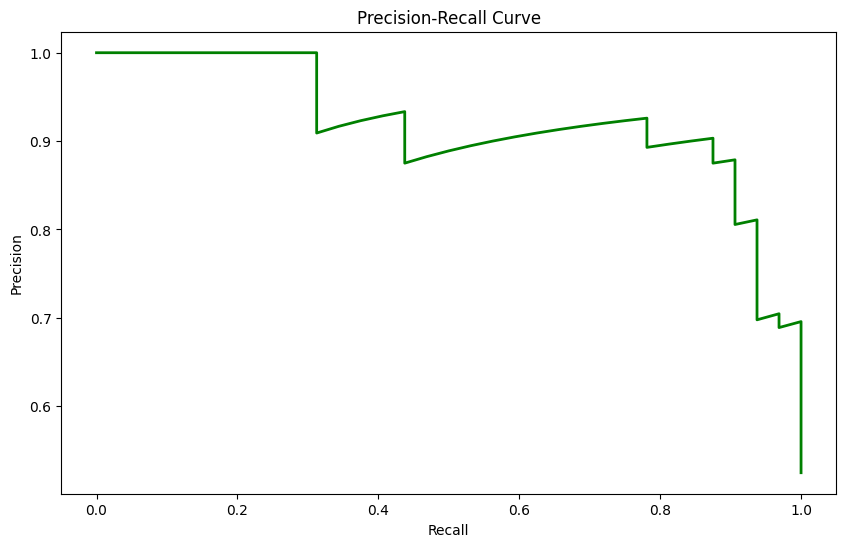

In [40]:
# Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

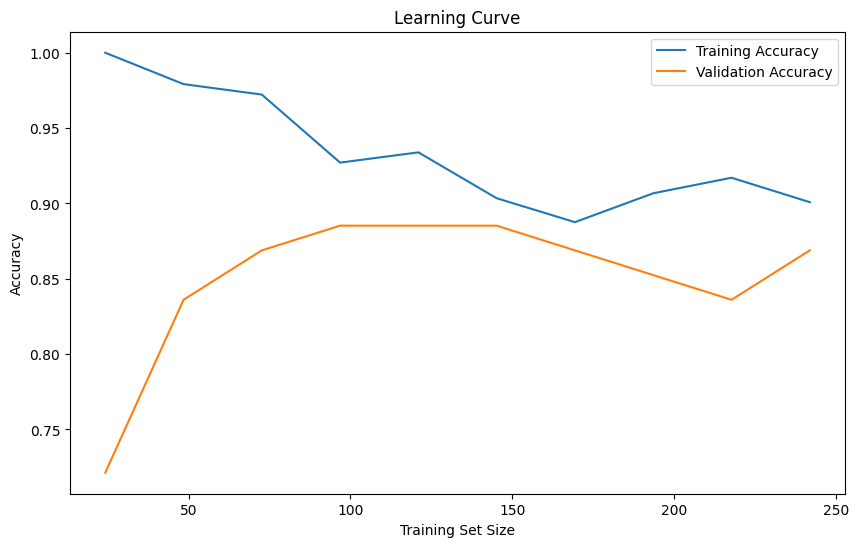

In [41]:
# Learning Curve

# Define a function to train the model on a subset of the data
def train_model_on_subset(X_train_subset, y_train_subset):
    model = HeartDiseaseNN()
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_subset).squeeze()
        loss = criterion(outputs, y_train_subset)
        loss.backward()
        optimizer.step()
    
    return model

# Define the sizes of the training set to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Arrays to hold the training and validation scores
train_scores = []
val_scores = []

# Loop over the different training set sizes
for train_size in train_sizes:
    # Determine the number of samples in this subset
    n_samples = int(len(X_train) * train_size)
    
    # Select the subset of the data
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]
    
    # Train the model on this subset
    model = train_model_on_subset(X_train_subset, y_train_subset)
    
    # Calculate the accuracy on the training subset
    with torch.no_grad():
        train_outputs = model(X_train_subset).squeeze()
        train_predicted = (train_outputs >= 0.5).float()
        train_accuracy = (train_predicted == y_train_subset).float().mean().item()
        train_scores.append(train_accuracy)
    
    # Calculate the accuracy on the full validation set
    with torch.no_grad():
        val_outputs = model(X_test).squeeze()
        val_predicted = (val_outputs >= 0.5).float()
        val_accuracy = (val_predicted == y_test).float().mean().item()
        val_scores.append(val_accuracy)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train), train_scores, label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

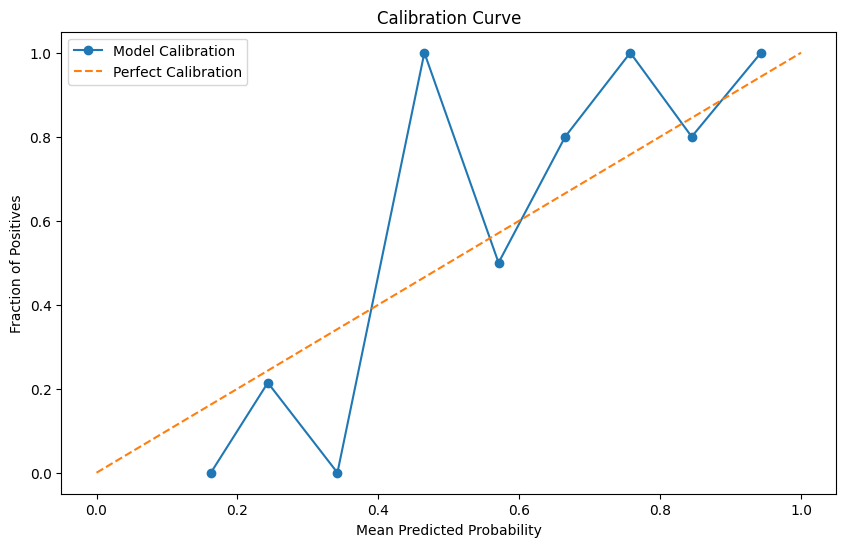

In [42]:
# Calibration Curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [43]:
# Save Final Model
torch.save(final_model.model.state_dict(), 'final_model.pth')